In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.base.model import GenericLikelihoodModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import sys
import re

from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import multivariate_normal

sys.path.append("../")
import vuong_tests11 as vuong_tests_fast

In [2]:
class JointNormal1(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([params[0], 0.0], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())
    
    
class JointNormal2(GenericLikelihoodModel):
    
    def loglikeobs(self, params):
        data = np.concatenate([[self.endog],self.exog.transpose()],axis=0)
        mult_rv = stats.multivariate_normal([0.0, params[0]], [[1,0],[0,1]])
        return mult_rv.logpdf(data.transpose())


def setup_shi(yn,xn):
    # model 1 grad, etc.
    nobs = yn.shape[0]
    model1_param = np.array([yn.mean()])
    model2_param = np.array([xn.mean()])
    
    model1_deriv = JointNormal1(yn,xn)
    ll1 = model1_deriv.loglikeobs(model1_param)
    grad1 =  model1_deriv.score_obs(model1_param).reshape( (nobs,1) )
    hess1 = model1_deriv.hessian(model1_param)
    
    
    model2_deriv = JointNormal2(yn,xn)
    ll2 = model2_deriv.loglikeobs(model2_param)
    grad2 =  model2_deriv.score_obs(model2_param).reshape( (nobs,1) )  
    hess2 = model2_deriv.hessian(model2_param)
    
    return ll1,grad1,hess1,model1_param,ll2,grad2,hess2,model2_param

def gen_data(beta= 1.5, nobs=1000):
    cov = [[25, 0], [0, 1]]
    data = np.random.multivariate_normal([beta,beta], [[25,0],[0,1]],  nobs)
    return data[:,0],data[:,1],nobs

yn,xn,nobs = gen_data()
ll1,grad1,hess1,params1,ll2,grad2,hess2,params2 = setup_shi(yn,xn)
print(grad1.shape,hess1.shape)
#NOTE! Weird size distortions with shi's test when theta = .5....

(1000, 1) (1, 1)


Simulation 200/2000
Simulation 400/2000
Simulation 600/2000
Simulation 800/2000
Simulation 1000/2000
Simulation 1200/2000
Simulation 1400/2000
Simulation 1600/2000
Simulation 1800/2000
Simulation 2000/2000
Figure saved to: paper_figs_0928/denom_densityplot_n200_beta0_epsilon05_True.pdf


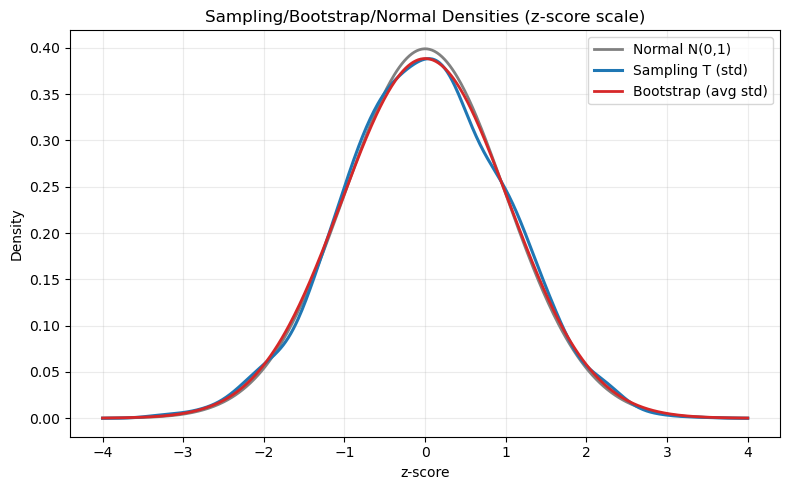

\begin{tabular}{lrrrr}
\toprule
{} &  Skewness &  Excess kurtosis &     q2 &   q97 \\
\midrule
Sampling T (std)    &    -0.035 &           -0.056 & -2.009 & 1.959 \\
Bootstrap (avg std) &    -0.001 &            0.002 & -1.954 & 1.954 \\
Normal N(0,1)       &     0.000 &            0.000 & -1.960 & 1.960 \\
\bottomrule
\end{tabular}



C:\Users\ericsc\AppData\Local\Temp\ipykernel_15592\559429124.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results["summary"].to_latex(float_format=float_fmt, column_format="lrrrr"))


In [3]:
def density_and_summary(
    setup_shi, gen_data, 
    num_sims=1000, trials=1000, epsilon=0.5, seed=2024,
    zmin=-4, zmax=4, G=512, data_tuned_epsilon=True,
    kde=True, hist_bins=100, bw_method='scott', alpha=0.05):

    rng = np.random.default_rng(seed)
    Ts = np.empty(num_sims)

    # For shape summaries
    boot_skew, boot_kurt, boot_q025, boot_q975 = [],[],[],[]
    z_grid = np.linspace(zmin, zmax, G)
    dens_bootstrap_sum = np.zeros_like(z_grid)
    all_boot_zscores = []      # for pooled histogram if desired

    crit_lo, crit_hi = alpha/2, 1-alpha/2

    for sim in range(num_sims):
        yn, xn, _ = gen_data()
        ll1, grad1, hess1, params1, ll2, grad2, hess2, params2 = setup_shi(yn, xn)
        if data_tuned_epsilon:
            epsilon = vuong_tests_fast.compute_optimal_epsilon(ll1, grad1, hess1, params1, ll2, grad2, hess2, params2, alpha=alpha)
        
        stat_dist, test_stat = vuong_tests_fast.pairwise_bootstrap_distr(
            ll1, grad1, hess1, params1, ll2, grad2, hess2, params2,
            epsilon=epsilon, trials=trials, biascorrect=True)
        Ts[sim] = test_stat

        # Standardize bootstrap within rep
        mB, sB = stat_dist.mean(), stat_dist.std(ddof=1)
        zstar = (stat_dist - mB) / sB
        all_boot_zscores.append(zstar)

        boot_skew.append(stats.skew(zstar, bias=False))
        boot_kurt.append(stats.kurtosis(zstar, fisher=True, bias=False))
        qlo, qhi = np.quantile(zstar, [crit_lo, crit_hi])
        boot_q025.append(qlo)
        boot_q975.append(qhi)

        if kde:
            kdeobj = stats.gaussian_kde(zstar, bw_method=bw_method) # try 'silverman' or scalar * 'scott'
            dens_bootstrap_sum += kdeobj(z_grid) / num_sims
        if (sim+1)%max(1,num_sims//10)==0:
            print(f"Simulation {sim+1}/{num_sims}")

    # Empirical distribution of the MC statistics
    Z = (Ts - Ts.mean())/Ts.std(ddof=1)
    if kde:
        kde_samp = stats.gaussian_kde(Z, bw_method=bw_method)
        dens_sampling = kde_samp(z_grid)
        dens_bootstrap = dens_bootstrap_sum
    else:  # pooled histogram (for less smoothing)
        allboot = np.concatenate(all_boot_zscores)
        dens_bootstrap, _ = np.histogram(allboot, bins=hist_bins, range=(zmin,zmax), density=True)
        zg = np.linspace(zmin, zmax, len(dens_bootstrap))
        dens_sampling, _ = np.histogram(Z, bins=hist_bins, range=(zmin, zmax), density=True)
        z_grid = zg

    dens_normal = stats.norm.pdf(z_grid)
    summary = pd.DataFrame({
        "Skewness": [
            stats.skew(Z, bias=False), np.mean(boot_skew), 0.0],
        "Excess kurtosis": [
            stats.kurtosis(Z, fisher=True, bias=False), np.mean(boot_kurt), 0.0],
        f"q{int(100*crit_lo)}": [
            np.quantile(Z, crit_lo), np.mean(boot_q025), stats.norm.ppf(crit_lo)],
        f"q{int(100*crit_hi)}": [
            np.quantile(Z, crit_hi), np.mean(boot_q975), stats.norm.ppf(crit_hi)],
    }, index=["Sampling T (std)", "Bootstrap (avg std)", "Normal N(0,1)"])
    return dict(
        z_grid=z_grid,
        dens_sampling=dens_sampling,
        dens_bootstrap_mean=dens_bootstrap,
        dens_normal=dens_normal,
        summary=summary,
        Ts=Ts,
        Z=Z,
        boot_zscores=all_boot_zscores
    )

def plot_zscore_densities(results, title="Densities on z-score scale",
                          nobs=None, beta=None, epsilon=None, data_tuned_epsilon=None):
    plt.figure(figsize=(8,5))
    plt.plot(results["z_grid"], results["dens_normal"], color="gray", lw=2, label="Normal N(0,1)")
    plt.plot(results["z_grid"], results["dens_sampling"], color="#1f77b4", lw=2.2, label="Sampling T (std)")
    plt.plot(results["z_grid"], results["dens_bootstrap_mean"], color="#d62728", lw=2, label="Bootstrap (avg std)")
    plt.xlabel("z-score")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    fname = f"paper_figs_0928/denom_densityplot_n{nobs}_beta{beta}_epsilon{str(epsilon).replace('.','')}_{data_tuned_epsilon}.pdf"
    plt.savefig(fname)
    print(f"Figure saved to: {fname}")
    plt.show()

def print_latex_summary(results, float_fmt="%.3f"):
    print(results["summary"].to_latex(float_format=float_fmt, column_format="lrrrr"))
    
#########
# Example usage:
num_sims = 2000
trials = 2000
epsilon = 0.5
beta = 0
nobs = 200
kde=True
data_tuned_epsilon = True

setup_shi_ex = lambda yn,xn: setup_shi(yn,xn)
gen_data_ex = lambda : gen_data(nobs=nobs, beta=beta)


results = density_and_summary(
    setup_shi_ex,gen_data_ex,kde=kde,
    num_sims=num_sims, trials=trials,
    epsilon=epsilon, seed=2024, data_tuned_epsilon= data_tuned_epsilon)

plot_zscore_densities(results, title="Sampling/Bootstrap/Normal Densities (z-score scale)",
                     nobs=nobs, beta=beta, epsilon=epsilon, data_tuned_epsilon=data_tuned_epsilon)
print_latex_summary(results)

Simulation 200/2000
Simulation 400/2000
Simulation 600/2000
Simulation 800/2000
Simulation 1000/2000
Simulation 1200/2000
Simulation 1400/2000
Simulation 1600/2000
Simulation 1800/2000
Simulation 2000/2000
Figure saved to: paper_figs_0928/denom_densityplot_nNone_betaNone_epsilonNone_None.pdf


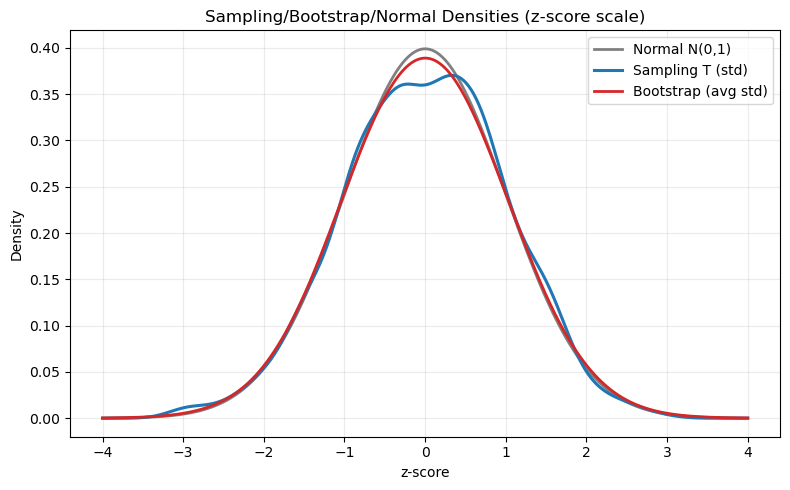

\begin{tabular}{lrrrr}
\toprule
{} &  Skewness &  Excess kurtosis &     q2 &   q97 \\
\midrule
Sampling T (std)    &    -0.107 &           -0.074 & -1.996 & 1.849 \\
Bootstrap (avg std) &     0.004 &            0.046 & -1.950 & 1.956 \\
Normal N(0,1)       &     0.000 &            0.000 & -1.960 & 1.960 \\
\bottomrule
\end{tabular}



C:\Users\ericsc\AppData\Local\Temp\ipykernel_15592\559429124.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results["summary"].to_latex(float_format=float_fmt, column_format="lrrrr"))


In [4]:
#########
# Example usage:

beta = 0
nobs = 100
data_tuned_epsilon = True

setup_shi_ex = lambda yn,xn: setup_shi(yn,xn)
gen_data_ex = lambda : gen_data(nobs=nobs, beta=beta)


results = density_and_summary(
    setup_shi_ex,gen_data_ex,
    num_sims=num_sims, trials=trials,kde=kde,
    epsilon=epsilon, seed=2024, data_tuned_epsilon= data_tuned_epsilon)

plot_zscore_densities(results, title="Sampling/Bootstrap/Normal Densities (z-score scale)")
print_latex_summary(results)

Simulation 200/2000
Simulation 400/2000
Simulation 600/2000
Simulation 800/2000
Simulation 1000/2000
Simulation 1200/2000
Simulation 1400/2000
Simulation 1600/2000
Simulation 1800/2000
Simulation 2000/2000
Figure saved to: paper_figs_0928/denom_densityplot_nNone_betaNone_epsilonNone_None.pdf


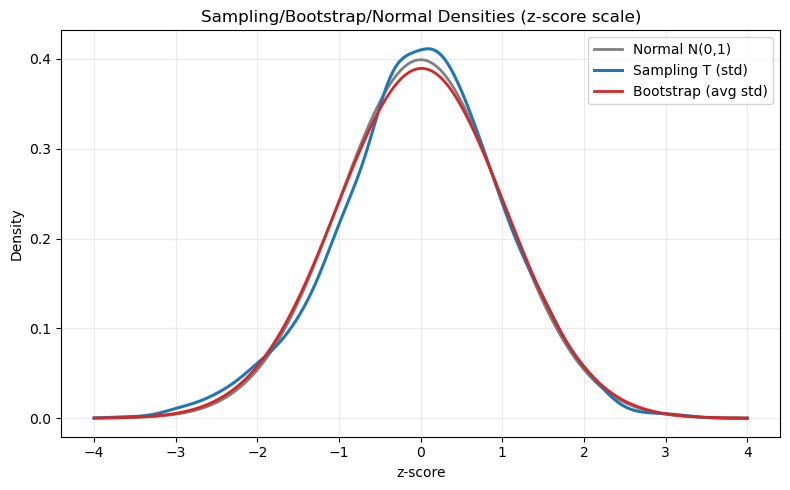

\begin{tabular}{lrrrr}
\toprule
{} &  Skewness &  Excess kurtosis &     q2 &   q97 \\
\midrule
Sampling T (std)    &    -0.191 &            0.225 & -2.104 & 1.899 \\
Bootstrap (avg std) &    -0.017 &           -0.006 & -1.964 & 1.945 \\
Normal N(0,1)       &     0.000 &            0.000 & -1.960 & 1.960 \\
\bottomrule
\end{tabular}



C:\Users\ericsc\AppData\Local\Temp\ipykernel_15592\559429124.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results["summary"].to_latex(float_format=float_fmt, column_format="lrrrr"))


In [5]:
#########
# Example usage:

beta = 1.5
nobs = 200
data_tuned_epsilon = True

setup_shi_ex = lambda yn,xn: setup_shi(yn,xn)
gen_data_ex = lambda : gen_data(nobs=nobs, beta=beta)


results = density_and_summary(
    setup_shi_ex,gen_data_ex,
    num_sims=num_sims, trials=trials,kde=kde,
    epsilon=epsilon, seed=2024, data_tuned_epsilon= data_tuned_epsilon)

plot_zscore_densities(results, title="Sampling/Bootstrap/Normal Densities (z-score scale)")
print_latex_summary(results)